# Initiating the environment

Before any SARIMA model can be implemented, the python environment needs to be initialized. This is done by importing the relevant packages and setting some global variables.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import pickle as pkl

import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn import metrics


In [2]:
machine = 'local'

if machine == 'Snellius':
    # For retrieving the set of aggregated scaling vectors
    PRED_VAR_PATH = '/gpfs/work1/0/ctdas/awoude/Ritten/predictor_vars/'

    # used for storing the trained model
    SAVE_DIR = pers_file_dir = '/gpfs/work1/0/ctdas/awoude/Ritten/trained_models/'

    # used for storing the scaling factor produced bij ML models
    SF_DIR = '/gpfs/work1/0/ctdas/awoude/Ritten/fitted_sf/'

    # used for storing the trained model
    RESULTS_DIR = '/gpfs/work1/0/ctdas/awoude/Ritten/results/'

elif machine == 'local':
    PRED_VAR_PATH = './'  # For retrieving the set of aggregated scaling vectors

    SAVE_DIR = pers_file_dir = './trained_models/'  # used for storing the trained model

    SF_DIR = './fitted_sf/'  # used for storing the scaling factor produced bij ML models

    RESULTS_DIR = './results/'

FIG_DIR = '../figures/'

The data used for fitting the model is loaded afterwards. Note that not all data is used, as we want to set aside some 'clean' data for the final testing of our models.

In [3]:
with xr.open_dataset(PRED_VAR_PATH + 'vars_per_eco_update.nc') as ds:
    complete_ds = ds

# before moving forward, some data is put aside to be used for model validation later. Going for the classical 80-20% split
train_ds = complete_ds.loc[dict(time=slice("2000-01-01","2017-01-01"))]
print(train_ds)


<xarray.Dataset>
Dimensions:           (time: 888, lon: 360, lat: 180, eco_regions: 68)
Coordinates:
  * time              (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2016-12-31
  * lon               (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat               (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * eco_regions       (eco_regions) float64 1.0 3.0 4.0 ... 204.0 206.0 209.0
Data variables: (12/50)
    regions           (lat, lon) float32 ...
    grid_cell_weight  (lat, lon) float64 ...
    grid_cell_area    (lat, lon) float32 ...
    TER               (lat, lon) float64 ...
    monthly_flux      (eco_regions, time) float64 ...
    smoothed_flux     (eco_regions, time) float64 ...
    ...                ...
    sd_MIN            (eco_regions, time) float64 ...
    sd_MAX            (eco_regions, time) float64 ...
    sf_AVG            (eco_regions, time) float64 ...
    sf_MAX            (eco_regions, time) float64 ...
    s10m_AVG          (eco_

# Finding the hyper-parameters

In order for SARIMA to work properly, 7 distinct hyperparemeters need to found for each model. These parameters are:
* p and seasonal P: indicate number of autoregressive terms (lags of the stationarized series)
* d and seasonal D: indicate differencing that must be done to stationarize series
* q and seasonal Q: indicate number of moving average terms (lags of the forecast errors)
* s: indicates seasonal length in the data

The autoregressive terms p and P are used to correlate different time points to each other. Using a ACF plot, the lag at which time points have the highest correlation can be determined. The largest significantly correlated non-seasonal lag is set as the value for p. P is determined in a similar fashion, but based the seasonal pattern.

The differencing terms d and D are needed to make the mean of the series stationary. Or in other words, compensate for any in- or decrease in the target variable over time. Whether this is needed is uncertain, but it is likely that the anthropogenic CO2 emissions affect the scaling factor. As such, the augmented Dickey-Fuller test is used to determine whether the data has a unit-root. If so, the d and D values need to be greater than 1. If not, both d and D are set to 0, essentially making a SARMA model.

The q and Q terms indicate a lag in the forecast error. This can be interpreted as how the deviation from the mean at time=t influences the target variable at t+1, t+2, t+3, ect. The longer the deviation from the mean affects the target variable, the higher the values for q and Q. As the original transition function within the EKF uses a smoother with a lag of 2, the value of q is likely to be 2 as well. The value for Q is still unknown and will be determined by looking at the PACF plot.

Finally, the s parameter needs to be determined as well. As seasonal patterns are expected to be on a yearly basis, the s parameter is expected to be 52. 

Let's start by checking whether the dataset is stationairy. If so, d and D can be set to 0. If not, values for d and D need to be found such that the data does become stationairy.

In [4]:
# For testing whether the data for each ecoregion is stationairy, the augmented Dicky-Fuller test is used.
# This test is applied to each of ecoregions. No correction for multiple comparisons is applied. This could 
# result in 5% of the results rejecting the null-hypothesis even though none of the eco-regions have a unit 
# root in their scaling-factor

from statsmodels.tsa.stattools import adfuller

# perform augmented Dickey-Fuller test

for region in train_ds.eco_regions:
    data = train_ds.sf_per_eco.loc[dict(eco_regions=region)]
    print(f'p-value for region {region.values}: {adfuller(data)[1]}')


p-value for region 1.0: 2.3549838013471e-30
p-value for region 3.0: 5.282510054516942e-16
p-value for region 4.0: 1.0754301962816621e-13
p-value for region 7.0: 2.39427126633777e-18
p-value for region 8.0: 8.275227540294857e-10
p-value for region 9.0: 0.0
p-value for region 10.0: 4.779771292392095e-24
p-value for region 11.0: 2.7384977061946964e-17
p-value for region 15.0: 1.8626073951694753e-21
p-value for region 16.0: 0.0
p-value for region 19.0: 0.0
p-value for region 20.0: 0.0
p-value for region 21.0: 0.0
p-value for region 22.0: 0.0
p-value for region 23.0: 0.0
p-value for region 24.0: 2.2888359245997556e-30
p-value for region 25.0: 1.2888179139099042e-20
p-value for region 26.0: 0.0
p-value for region 27.0: 0.0
p-value for region 29.0: 0.0
p-value for region 30.0: 3.1778229696954293e-28
p-value for region 31.0: 1.7681757942840372e-21
p-value for region 32.0: 1.5250985157011814e-13
p-value for region 33.0: 0.0
p-value for region 34.0: 4.91645305183904e-25
p-value for region 35.0: 

For all regions, the null-hypothesis of a unit-root existing within the set of all scaling factors (i.e. there is an increase or decrease over time) is rejected. Therefore, both the d and D terms are set to 0, effectively creating a SARMA model. 

Next up is determining the other hyperparameters.

191.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


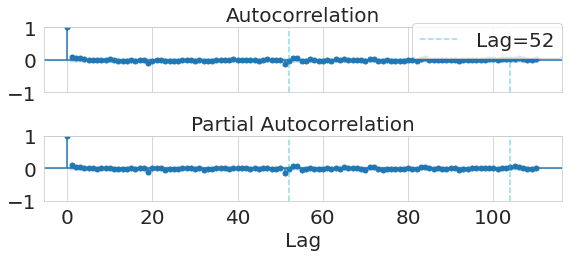

192.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


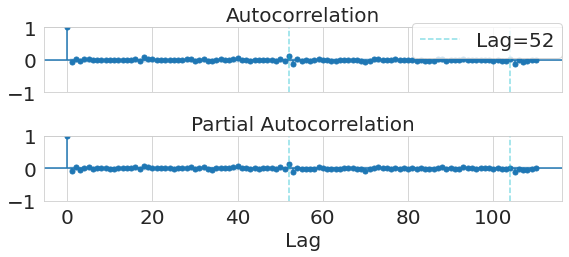

193.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


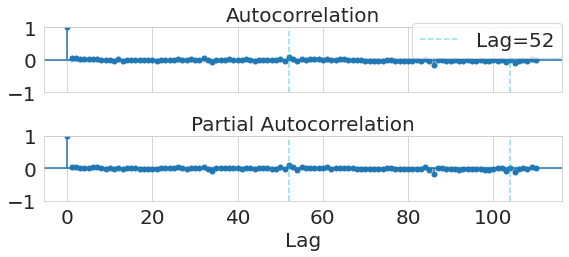

194.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


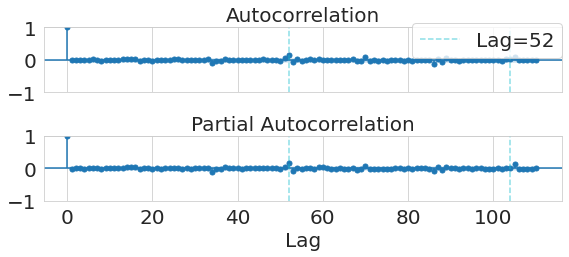

195.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


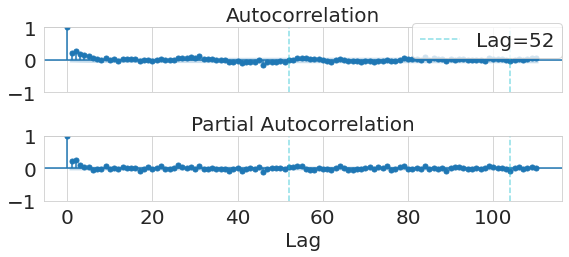

196.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


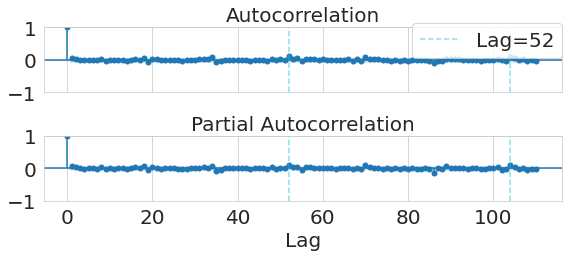

197.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


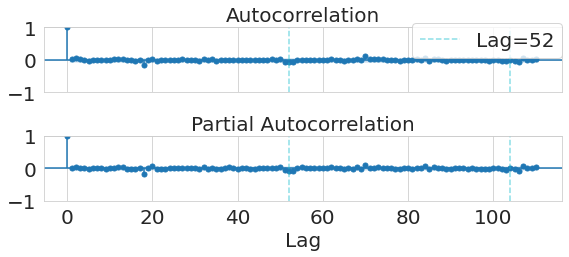

198.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


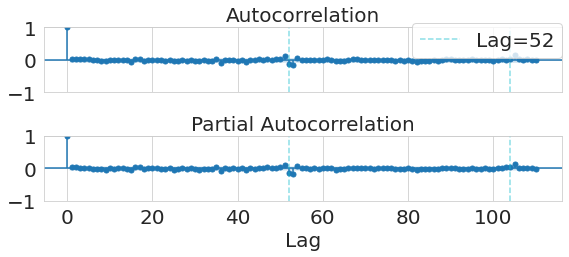

199.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


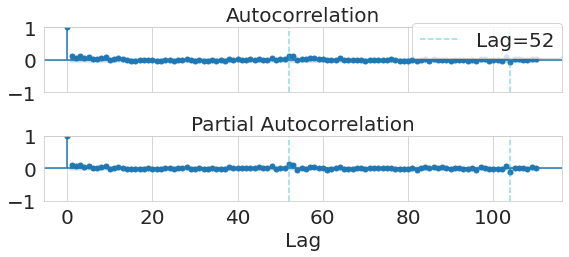

200.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


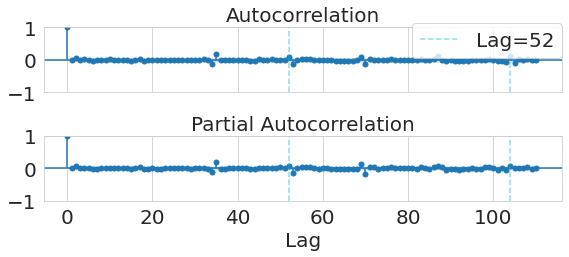

201.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


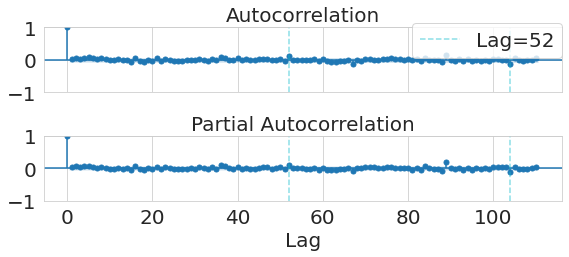

202.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


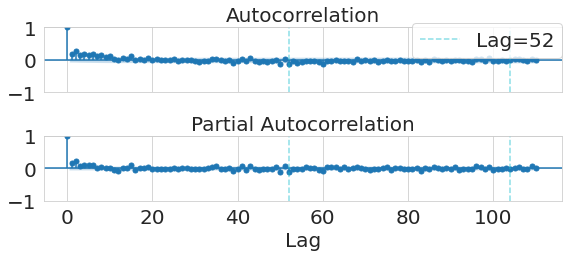

204.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


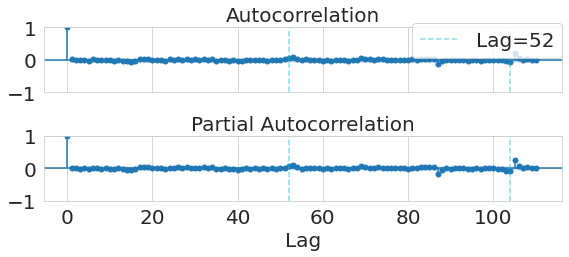

206.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


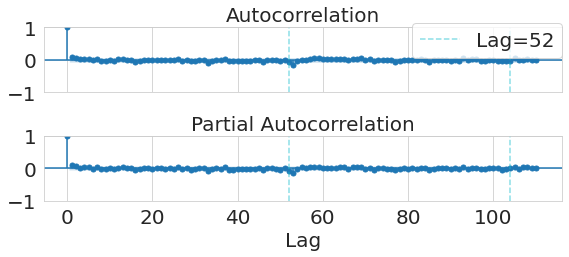

209.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


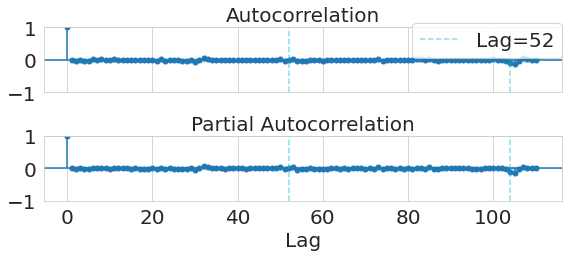

In [10]:
# The second step is to find the values for p and P using ACF and PACF. Since analysing all 68 used ecoregions is 
# computationally expensive and not really necessary, only the eco-regions from the transcom region deemed most reliable are
# included in the analysis. This is the Europe TransCom region, with has the eco-regions 191 to 209.

for region in train_ds.eco_regions.sel(eco_regions= slice(191.0, 210.0)):
    print(str(region.values))
    dat = train_ds.sf_per_eco.loc[dict(eco_regions=region)]
    fig, ax = plt.subplots(2,1, figsize=(8, 4), sharex=True)
    fig = sm.graphics.tsa.plot_acf(dat, lags=110, ax=ax[0])
    # change the fontsize
    ax[0].tick_params(labelsize=20)
    ax[0].set_title(ax[0].get_title(), fontsize=20)

    # ax[0].set_ticks(fontsize=20)
    # ax[0].set_ticks(fontsize=20)
    # ax[0].title(fontsize=20)
    ax[0].vlines([52, 104], -1, 1, color='C09', linestyles='--', alpha=0.5)
    fig = sm.graphics.tsa.plot_pacf(dat, lags=110, ax=ax[1])
    ax[1].vlines([52, 104], -1, 1, color='C09', linestyles='--', label='Lag=52', alpha=0.5)

    ax[1].tick_params(labelsize=20)
    ax[1].set_title(ax[1].get_title(), fontsize=20)
    ax[1].set_xlabel('Lag', fontsize=20)
    # ax[1].yticks(fontsize=20)
    # ax[1].xticks(fontsize=20)
    # ax[1].title(fontsize=20)
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0., 0.99, 1., -0.1), fontsize=20)
    plt.suptitle('ecoregion: ' + str(region.values), fontsize=20)
    # ax[0].yticks(fontsize=20)
    # ax[0].xticks(fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(FIG_DIR+f'/(P)AC/{region}.pdf')
    plt.show()

# Conclusions ACF and PACF:
Lets first determine the AR terms of p and P. This is done by looking at the ACF plots.  Generally speaking, a peak is observed around lag=52 and lag=104. This correlates to a seasonal trend of a year. Next to the peaks at 52 and 104, some peaks are also observed at 52+1 and 104+1, indicating that the P should be either 0 or 1. Closer to lag=0, some models also show a peak at either lag=1, lag=2, or both. This indicated that the p value should be 2.

The PACF plots show a very similar trend. Therefore, the MA terms of q and Q are copied from their AR counter parts: q=2 and Q=1.

This means we arrive at our final model: ARIMA(p,d,q)(P,D,Q)<sub>s</sub> = ARIMA(2,0,2)(1,0,1)<sub>52</sub>

Furthermore, it is reasonable that the mean scaling factor always remain approximately 1. Hence, an intercept term is added as well.

# Training the SARIMA models
After the model selection, it is now time to train the models. This is done usinging the startmodel.tsa.SARIMAX model, which uses maximum likelihood estimation to find values for the seasonal and the non-seasonal AR and MA terrms.

In [5]:
experiment_dir = './SARIMA_test_models/'

!ls -al $pers_file_dir

total 24
drwxrwxr-x  6 user user 4096 Oct  8 16:39 .
drwxrwxr-x 15 user user 4096 Nov  1 07:04 ..
drwxrwsr-x 19 user user 4096 Sep  5 21:45 monthly
drwxr-sr-x 19 user user 4096 Aug 31 16:08 SARIMA
drwxrwxr-x 19 user user 4096 Aug 17 14:33 SARIMA_backup
drwxrwxr-x 19 user user 4096 Oct  8 17:06 SARIMAX


191.0
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  888
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 52)   Log Likelihood               -1479.856
Date:                              Sun, 06 Nov 2022   AIC                           2975.713
Time:                                      17:13:04   BIC                           3014.025
Sample:                                           0   HQIC                          2990.358
                                              - 888                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0178      0.236      0.075      0.940      -0.445       0.481
ar.L1        

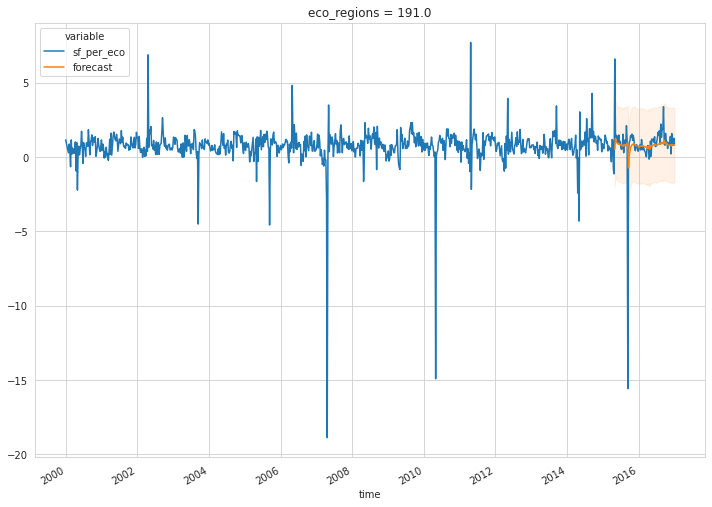

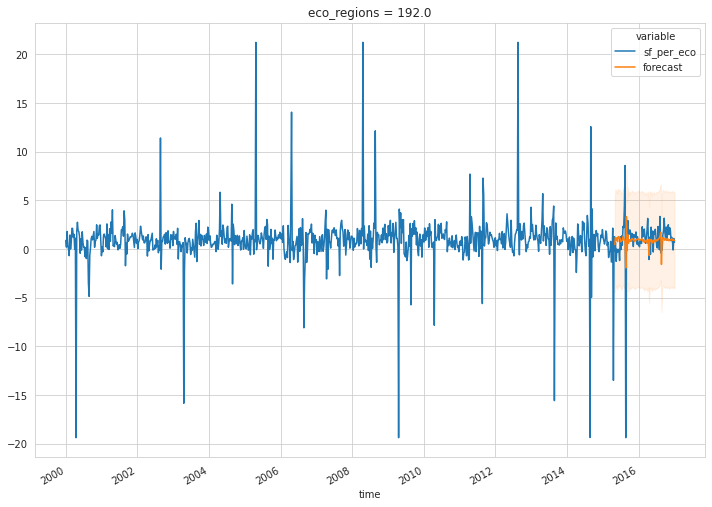

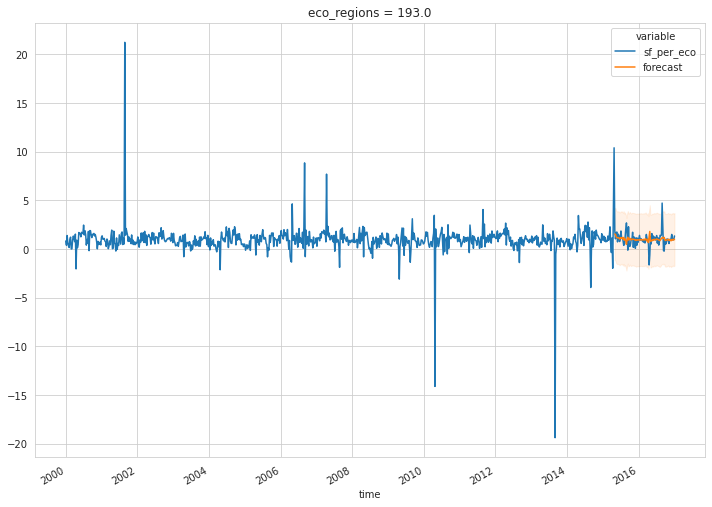

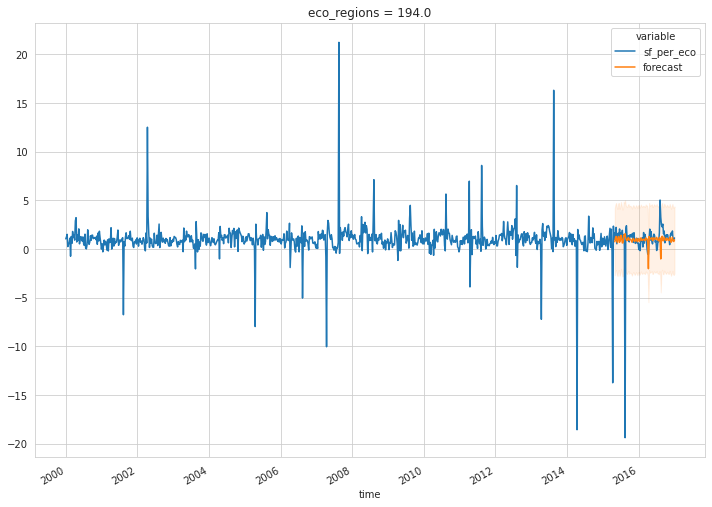

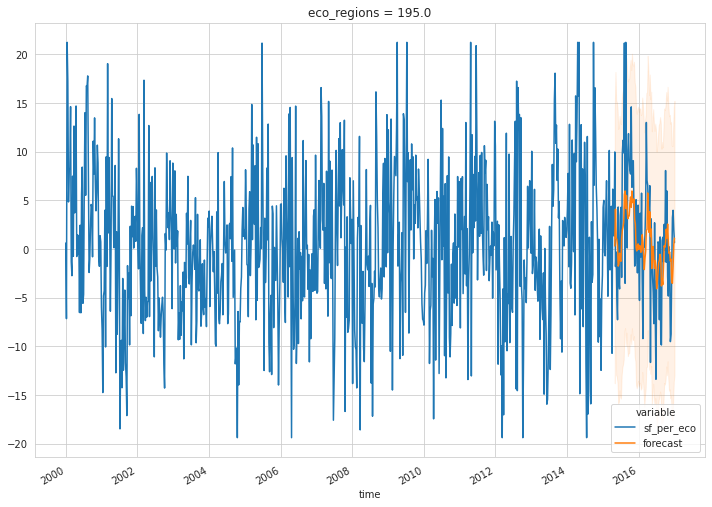

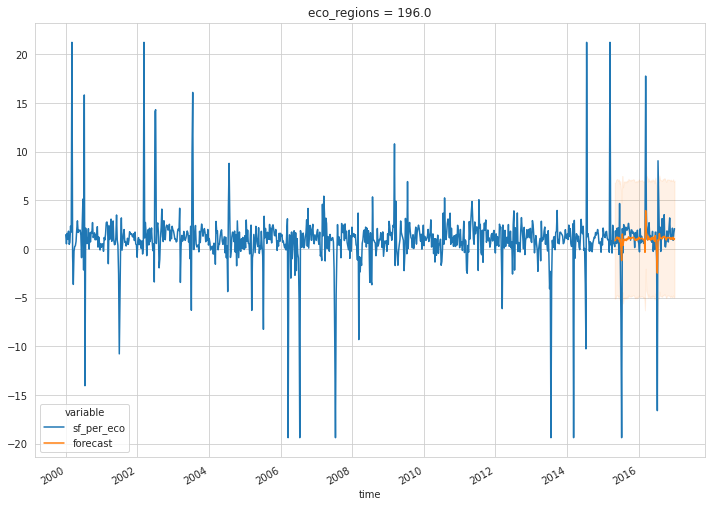

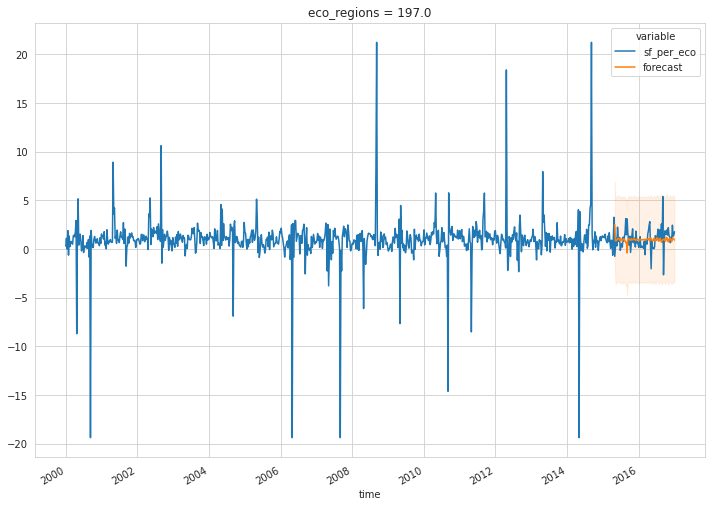

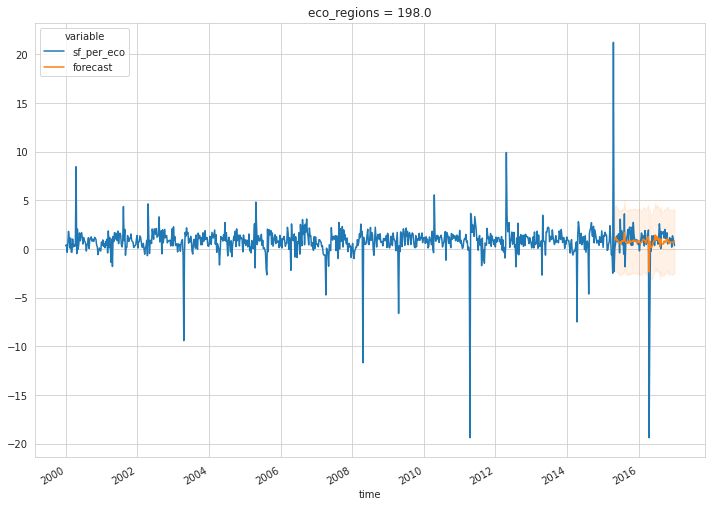

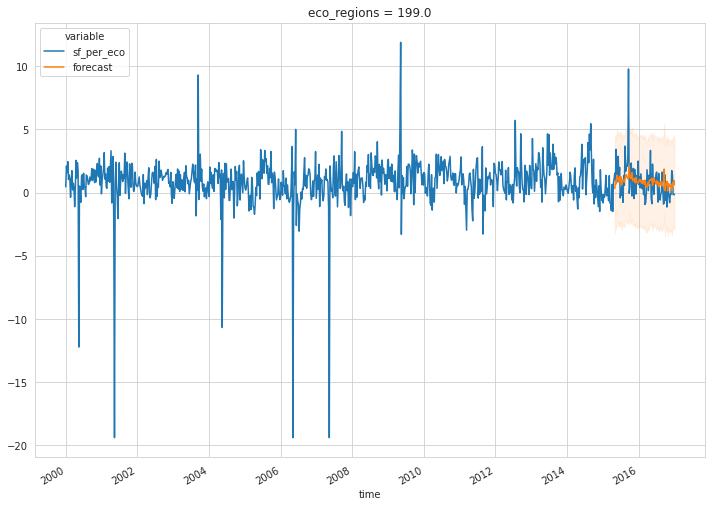

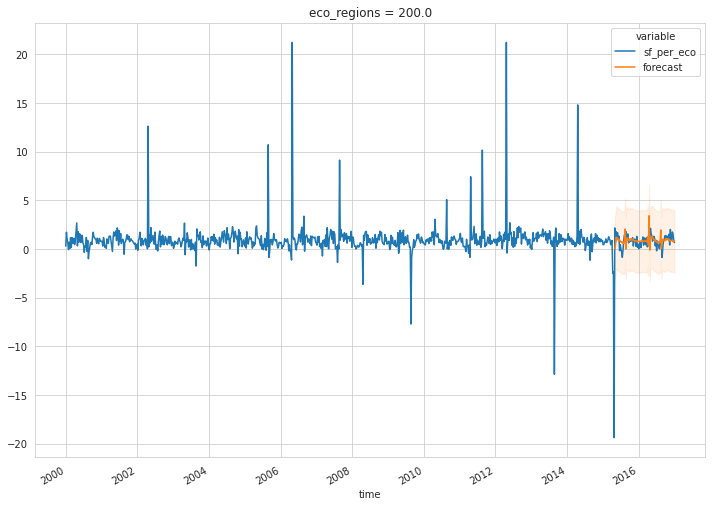

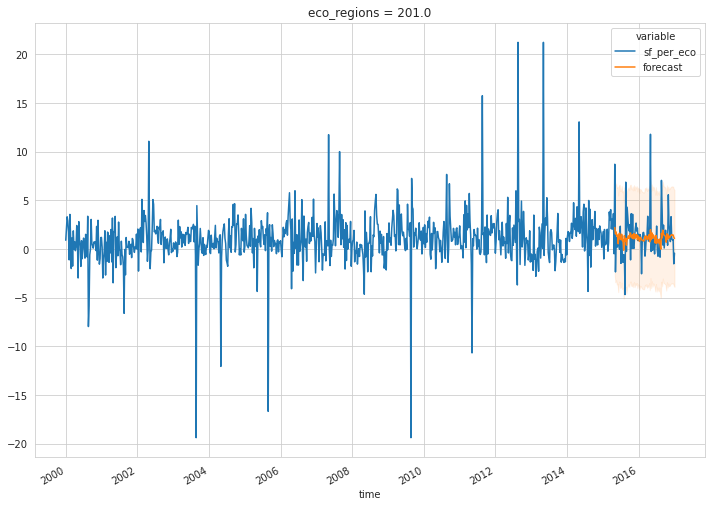

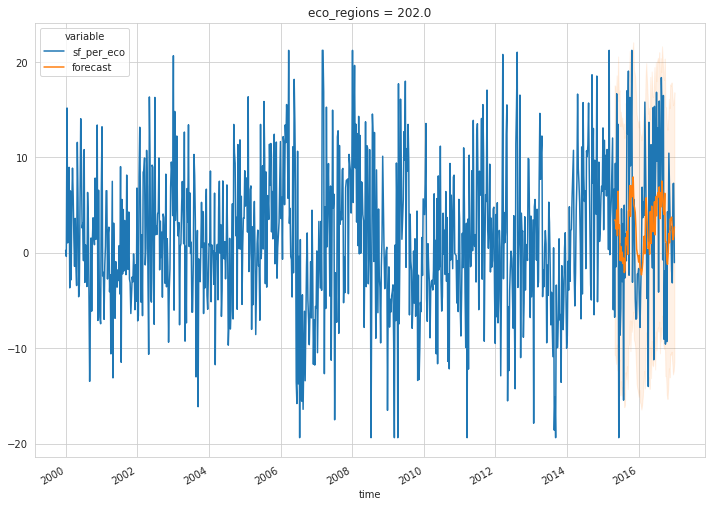

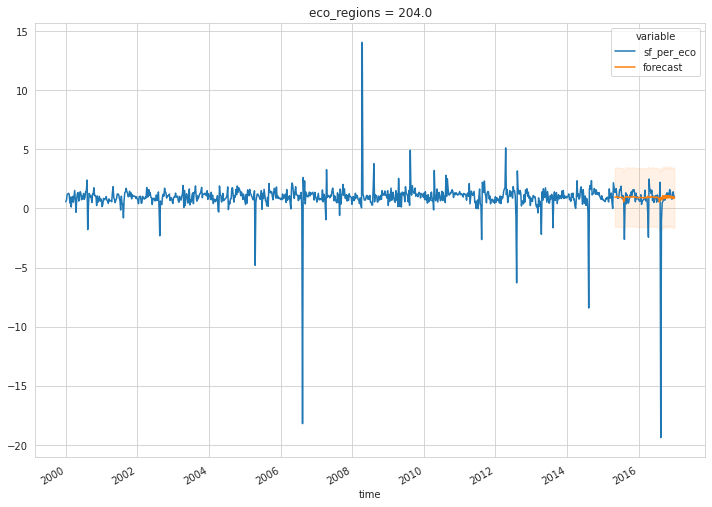

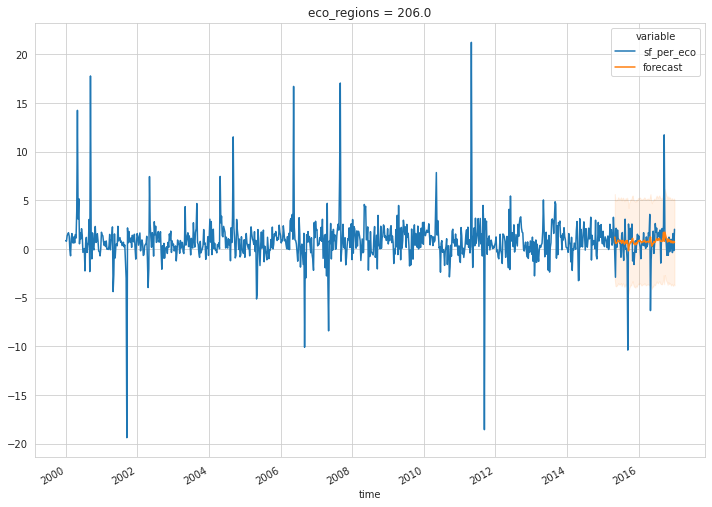

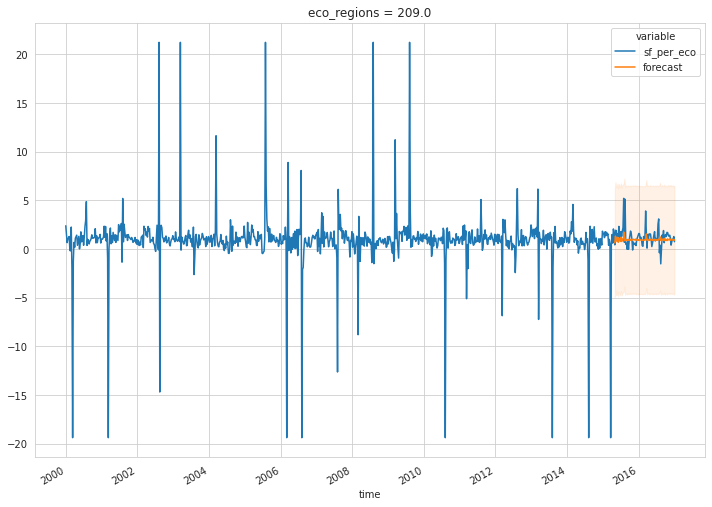

In [12]:
def load_model(region, data):
    model_path = pers_file_dir+'SARIMA/2000/SARIMA_'+region+'.pkl'
    with open(model_path, 'rb') as f:
        model = pkl.load(f)
        trained_model = sm.tsa.SARIMAX(data.values,
                                     order=(2,0,2),             # Defining the regular AR, I and MA dependencies
                                     seasonal_order=(1,0,1,52), # Defining the seasonal dependencies
                                     trend = 'c'                # Adding an intercept term
                                     )
        trained_model = trained_model.filter(model)
    return trained_model

for region in train_ds.eco_regions.sel(eco_regions= slice(191.0, 209.0)):
    print(str(region.values))
    data = train_ds.sf_per_eco.loc[dict(eco_regions=region)]
    
    try:
        trained_model = load_model(str(region.values), data)
    except ImportError:
        print('could not load previously trained model. Loading new one')

        model = sm.tsa.statespace.SARIMAX(data.values,
                                         order=(2,0,2),             # Defining the regular AR, I and MA dependencies
                                         seasonal_order=(1,0,1,52), # Defining the seasonal dependencies
                                         trend = 'c'                # Adding an intercept term
                                         )
        print(model)
        trained_model=model.fit(maxiter=100) # method='cg'
    print(trained_model.summary())
    prediction = trained_model.get_prediction(start=800)
    pred_ci = prediction.conf_int()
    pred_dat = prediction.predicted_mean

    print('\n Making prediction:')
    forecast = xr.DataArray(data = pred_dat, 
                            dims = ['time'],
                            coords = dict(time=data.time.isel(time=slice(800,888))),
                            name = 'forecast')

    # Plotting the predictions to give insights on the fit to the training data.
    xr.merge([data, forecast]).to_array().plot.line(x='time',figsize=(12,8))

    # Adding the uncertainty interval
    plt.fill_between(data.time.isel(time=slice(800,888)).values, pred_ci[:,0], pred_ci[:,1], color='C01', alpha=0.1)


A closer inspection of the summaries of the models show that there is large difference in the probabilities for the coefficients being non-zero. While for some models almost all coefficients are not significantly different from 0 (e.g. model 191.0), other models have only coefficients significantly different from 0 (e.g. model 194.0). What all models have in common, is that the sigma2 term, which is an indication of the remaining unexplained variance, is for all models significantly larger than 0. This is an indication that to models provide a poor fit to the training data and additional analysis is needed to determine whether a better model can be found.

We start of by taking another close look at the made predictions. If it is possible that some seasonal trends are not captured, we should go back to the drawing board and select a new model.

191.0


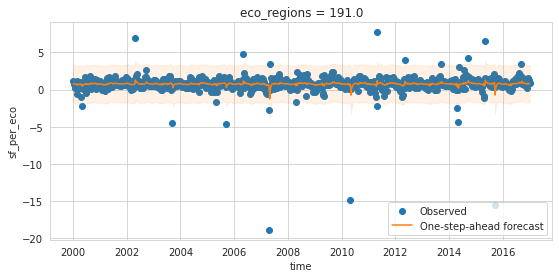

192.0


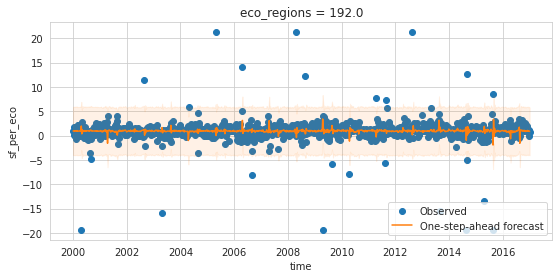

193.0


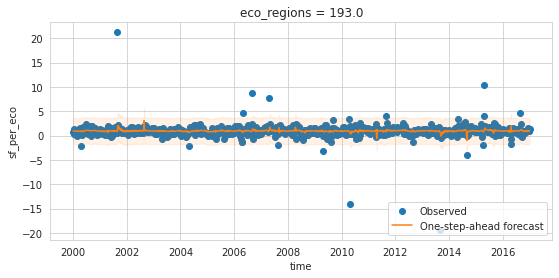

194.0


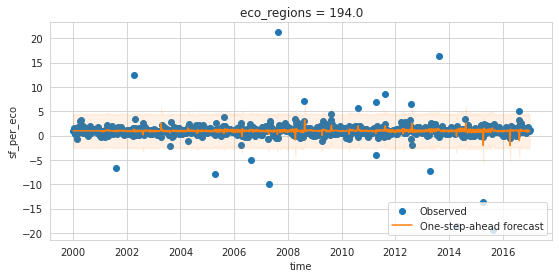

195.0


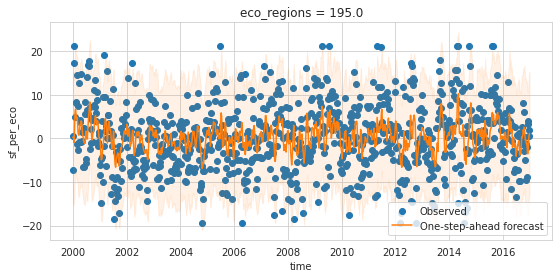

196.0


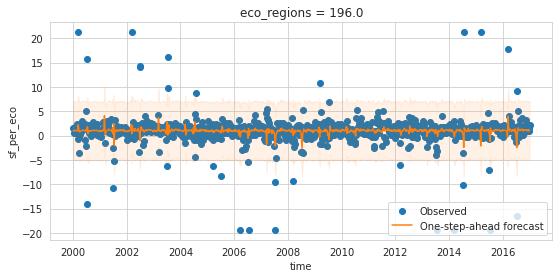

197.0


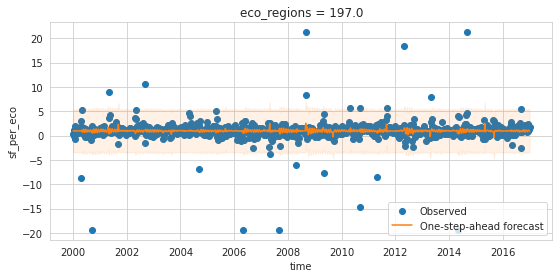

198.0


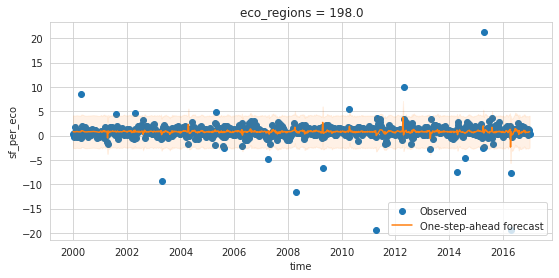

199.0


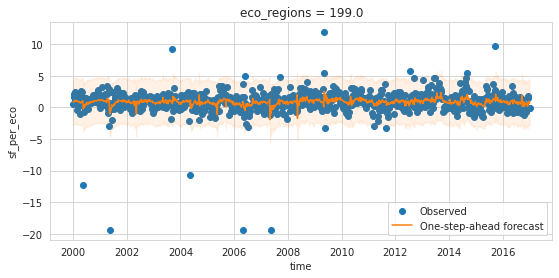

200.0


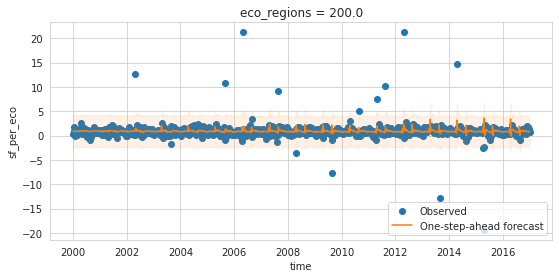

201.0


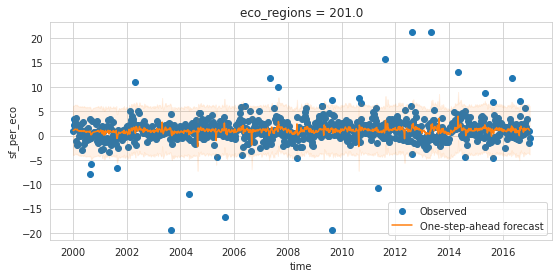

202.0


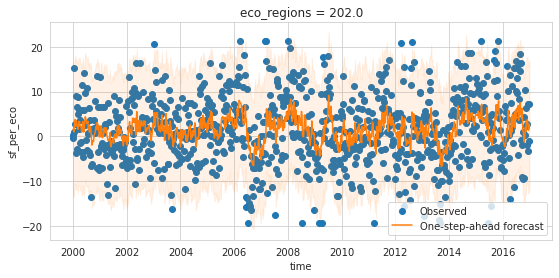

204.0


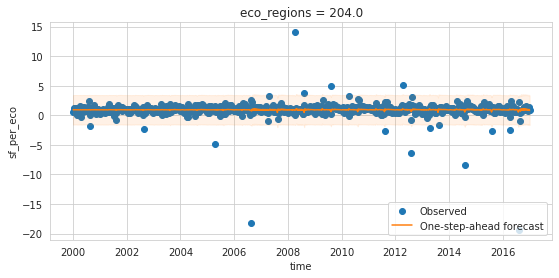

206.0


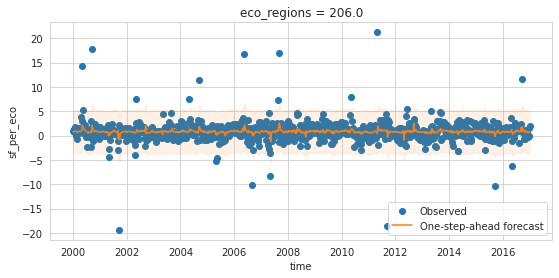

209.0


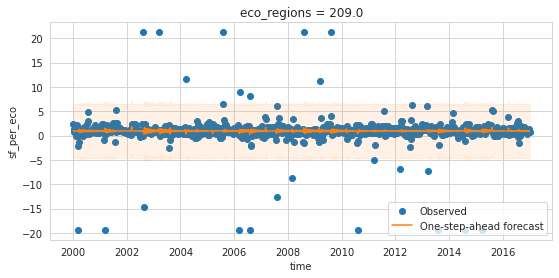

In [14]:

for region, data in train_ds.loc[dict(eco_regions=slice(190.0, 209.0))].sf_per_eco.groupby('eco_regions'):
    print(region)
    trained_model = load_model(str(region), data)
    # test_model = sm.tsa.statespace.SARIMAX(data.values,
    #                                      order=(2,0,2),             # Defining the regular AR, I and MA dependencies
    #                                      seasonal_order=(1,0,1,52), # Defining the seasonal dependencies
    #                                      trend = 'c'                # Adding an intercept term
    #                                      )
    # results = test_model.filter(trained_model.params)
    predict = trained_model.get_prediction()
    predict_ci = predict.conf_int()


    # Graph
    fig, ax = plt.subplots(figsize=(9,4))
    ax.set(title='Prediction sf ecoregegion 191', xlabel='Date', ylabel='Scaling factor')

    # Plot data points
    train_ds.sel(eco_regions=region).plot.scatter(x='time',y='sf_per_eco', ax=ax, label='Observed', c='C00')
    
    # Plot predictions
    plt.plot(train_ds.time.values, predict.predicted_mean, label='One-step-ahead forecast', c='C01')
    ci = predict_ci
    ax.fill_between(train_ds.time.values, ci[:,0], ci[:,1], color='C01', alpha=0.1)
    legend = ax.legend(loc='lower right')

    plt.show()


No clearly missed trend becomes apparent. Therefore, a test on the dependencies between the residuals is conducted to ensure no dependencies are left unused. This is done using the Ljung-box test.


In [16]:
for region, data in train_ds.loc[dict(eco_regions=slice(190.0, 209.0))].sf_per_eco.groupby('eco_regions'):
    print(region)
    trained_model = load_model(str(region), data)
    # test_model = sm.tsa.statespace.SARIMAX(data.values,
    #                                      order=(2,0,2),             # Defining the regular AR, I and MA dependencies
    #                                      seasonal_order=(1,0,1,52), # Defining the seasonal dependencies
    #                                      trend = 'c'                # Adding an intercept term
    #                                      )
    # results = trained_model.filter(trained_model.params)
    predict = trained_model.get_prediction(start=888)
    predict_ci = predict.conf_int()

    print(f'region: {region} - \n{sm.stats.acorr_ljungbox(trained_model.resid, lags=[110], return_df=True)}')

191.0
region: 191.0 - 
       lb_stat  lb_pvalue
110  63.909939   0.999867
192.0
region: 192.0 - 
       lb_stat  lb_pvalue
110  72.697399   0.997651
193.0
region: 193.0 - 
       lb_stat  lb_pvalue
110  67.640996   0.999498
194.0
region: 194.0 - 
       lb_stat  lb_pvalue
110  83.847037   0.969969
195.0
region: 195.0 - 
        lb_stat  lb_pvalue
110  137.104923    0.04094
196.0
region: 196.0 - 
       lb_stat  lb_pvalue
110  82.124408   0.978346
197.0
region: 197.0 - 
       lb_stat  lb_pvalue
110  71.481546   0.998339
198.0
region: 198.0 - 
        lb_stat  lb_pvalue
110  103.533598   0.655283
199.0
region: 199.0 - 
       lb_stat  lb_pvalue
110  66.249954   0.999688
200.0
region: 200.0 - 
       lb_stat  lb_pvalue
110  93.591881   0.868863
201.0
region: 201.0 - 
        lb_stat  lb_pvalue
110  123.353807   0.181203
202.0
region: 202.0 - 
        lb_stat  lb_pvalue
110  133.256429   0.065067
204.0
region: 204.0 - 
        lb_stat  lb_pvalue
110  120.504251   0.232252
206.0
region: 2

Using the Ljung-box test, we find that for no model, the null-hypothesis of the residuals not being independent of each other can be rejected. This means that we have to assume that the residuals are independent of each other and adding more auto-regression or moving average terms to the model is not likely to improve the performance.

In [ ]:
MAPE = metrics.mean_absolute_percentage_error(test_ds.sel(eco_regions=192.0).sf_per_eco.values, predict.predicted_mean)
RMSE = np.sqrt(metrics.mean_squared_error(test_ds.sel(eco_regions=192.0).sf_per_eco.values, predict.predicted_mean))
r2 = metrics.r2_score(test_ds.sel(eco_regions=192.0).sf_per_eco.values, predict.predicted_mean)

print(f'MAPE:{MAPE*100}%')
print(f'RMSE:{RMSE}')
print(f'R^2:{r2}')

In [ ]:
str(complete_data.time.dt.year.min().values)

In [ ]:
with open('./SARIMA_test_models/test_192.0.pkl', "rb") as file:
    results_192 = pkl.load(file)

true_dat = test_ds.sel(eco_regions=191.0).sf_per_eco.values
pred_dat = results_192.predicted_mean
flux_dat = test_ds.sel(eco_regions=191.0).prior_flux_per_s.values
for item in eval_model
print(eval_model(true_dat, pred_dat, flux_dat))


In [11]:

with open('./SARIMA_test_models/test_191.0.pkl', "rb") as file:
    results_191 = pkl.load(file)

true_dat = test_ds.sel(eco_regions=191.0).sf_per_eco.values
pred_dat = results_191.predicted_mean
flux_dat = test_ds.sel(eco_regions=191.0).prior_flux_per_s.values
print(eval_model(true_dat, pred_dat, flux_dat))


{'sf_ME': 0.11438042389738999, 'sf_MAPE': 1.8131300227381466, 'sf_RMSE': 0.9641062218468168, 'sf_r2': -0.014308024992293111, 'flux_ME': 35449.08136795087, 'flux_MAPE': 1.8131300141741657, 'flux_RMSE': 902066.5264112586, 'flux_r2': 0.7863753902447552}


In [12]:
with open('./SARIMA_test_models/test_192.0.pkl', "rb") as file:
    results_192 = pkl.load(file)

true_dat = test_ds.sel(eco_regions=191.0).sf_per_eco.values
pred_dat = results_192.predicted_mean
flux_dat = test_ds.sel(eco_regions=191.0).prior_flux_per_s.values
for item in eval_model
print(eval_model(true_dat, pred_dat, flux_dat))


{'sf_ME': 0.06129099044875648, 'sf_MAPE': 1.7907201207372365, 'sf_RMSE': 0.9315941029122636, 'sf_r2': 0.052948596852753105, 'flux_ME': -49910.47472931731, 'flux_MAPE': 1.7907201157669979, 'flux_RMSE': 1007592.3554717938, 'flux_r2': 0.7334713649399089}


Text(0.5, 0, 'time')

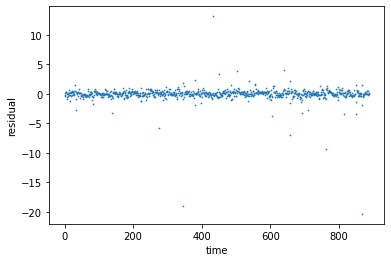

In [10]:
plt.scatter(range(len(trained_model.resid)), trained_model.resid, s=0.5)
plt.ylabel('residual')
plt.xlabel('time')

Text(0.5, 0, 'residual value')

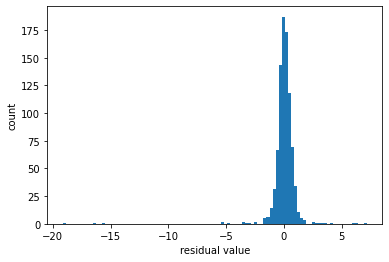

In [19]:
plt.hist(trained_model.resid, bins=100)
plt.ylabel('count')
plt.xlabel('residual value')

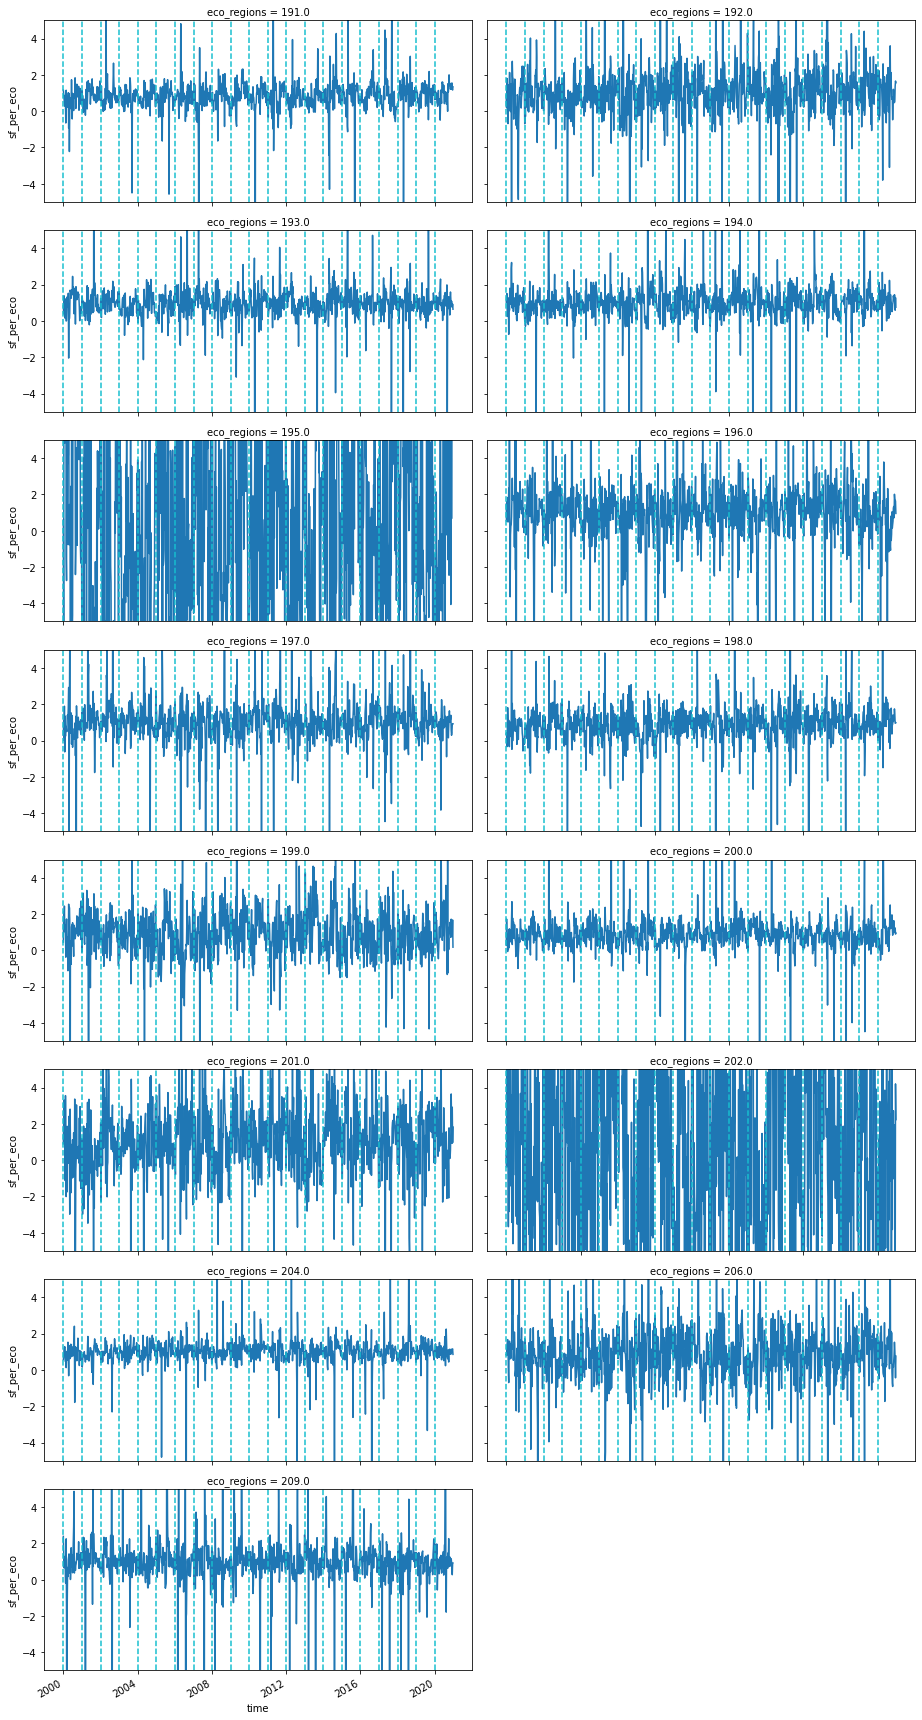

In [22]:
fig = complete_ds.sf_per_eco.sel(eco_regions=slice(191, 210)).plot(aspect=2, size=3, col="eco_regions", col_wrap=2)
dates = pd.DatetimeIndex(complete_ds.time.values)

line_dates = dates.where((dates.day <= 7) & (dates.month == 1))
for row_ax in fig.axes:
    # Add vertical lines to indicate the start of every year
    for ax in row_ax:
        ax.vlines(line_dates, -5, 5, color='C09', linestyles='--', label='year line')

plt.ylim((-5, 5))
plt.legend()